# Download Sample

Download Illustris galaxy sample.

In [2]:
import numpy as np
import h5py
from methods.get import get, get_sub_spectra, get_sub_url, get_sub_particles, get_sub_particles_fiber

First, define the sample dictionary where we will store all data, then get simulation details

In [3]:
r = get('http://www.tng-project.org/api/')
sim = get( r['simulations'][0]['url'] )
snap = get( get(sim['snapshots'])[125]['url'] ) # z = 0.1, snap 127
print(snap['number'])

127


Retrieve [PMSD supplementary catalog](http://www.illustris-project.org/data/docs/specifications/#sec4h)

In [4]:
temp = get('http://www.tng-project.org/api/%s'%sim['name'])
filename = get(temp['files']['pmsd'])

with h5py.File(filename, 'r') as hf:
    sh_id = hf['Snapshot_127']['SubfindID'][:]
    mstar_30 = np.log10(hf['Snapshot_127']['Mstar_30'][:] / sim['hubble'])


## Query

In [ ]:
subhalo_ids = sh_id[(mstar_30 > 10.0)]
shape = len(subhalo_ids)

with h5py.File('data/full_histories_illustris_hmass.h5','a') as f:
    
    if "Star Particles" not in list(f.keys()): f.create_group("Star Particles")
    if "Subhalos" not in list(f.keys()): f.create_group("Subhalos")

    ## delete fields ##
    for field in list(f["Subhalos"].keys()):
        del f['Subhalos/%s'%field]
            
    for field in list(f["Star Particles"].keys()):
        del f['Star Particles/%s'%field]
    

with h5py.File('data/full_histories_illustris_hmass.h5','a') as f:
    
    if "ID" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('ID',(shape,),dtype='i8',maxshape=(None,),data=np.ones(shape)*-1)
    
    if "Stellar Mass" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('Stellar Mass',(shape,),maxshape=(None,))
        
    if "Gas Metallicity" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('Gas Metallicity',(shape,),maxshape=(None,))
        
    if "Stellar Metallicity" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('Stellar Metallicity',(shape,),maxshape=(None,))
        
        f["Subhalos"].create_dataset('SFR',(shape,),maxshape=(None,))
        
    if "Star Forming Gas Mass" not in list(f["Subhalos"].keys()):
        f['Subhalos'].create_dataset('Star Forming Gas Mass',(shape,),maxshape=(None,))
        
    if "Stellar Mass 30kpc" not in list(f["Subhalos"].keys()):
        f['Subhalos'].create_dataset('Stellar Mass 30kpc',(shape,),maxshape=(None,))
        
    if "Stellar Metallicity 30kpc" not in list(f["Subhalos"].keys()):
        f['Subhalos'].create_dataset('Stellar Metallicity 30kpc',(shape,),maxshape=(None,))
        
    if "Index Start" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('Index Start',(shape,),dtype='i8',maxshape=(None,))
        
    if "Index Length" not in list(f["Subhalos"].keys()):
        f["Subhalos"].create_dataset('Index Length',(shape,),dtype='i8',maxshape=(None,))
    
    if "Formation Time" not in list(f["Star Particles"].keys()):
        f["Star Particles"].create_dataset('Formation Time',(0,),maxshape=(None,))
        
    if "Initial Mass" not in list(f["Star Particles"].keys()):
        f["Star Particles"].create_dataset('Initial Mass',(0,),maxshape=(None,))
        
    if "Metallicity" not in list(f["Star Particles"].keys()):
        f["Star Particles"].create_dataset('Metallicity',(0,),maxshape=(None,))
        

with h5py.File('data/full_histories_illustris_hmass.h5','a') as f:

    pidx = len(f["Star Particles/Formation Time"][:])
    print("Initial pidx:", pidx)
    
    for i, sid in enumerate(subhalo_ids):
        
        if sid in f["Subhalos/ID"][:]:
            continue

        if (i % 100) == 0: print(round(float(i)/len(subhalo_ids) * 100,2), "%")

        out = get(get_sub_url(sid, sim=sim['name'], snap=snap['number']));
        mstar, gas_metallicity, sfr, stellar_metallicity = [out[key] for key in \
                    ['mass_stars','gasmetallicitysfr','sfr','starmetallicity']]

        particles, star_forming_gas_mass, com = \
            get_sub_particles(sid, sim=sim['name'], snap=snap['number']);
        
        f["Subhalos/ID"][i] = sid
        f["Subhalos/Stellar Mass"][i] = (mstar * 1e10) / sim['hubble']
        f["Subhalos/Gas Metallicity"][i] = gas_metallicity
        f["Subhalos/SFR"][i] = sfr
        f["Subhalos/Star Forming Gas Mass"][i] = star_forming_gas_mass
        f["Subhalos/Stellar Mass 30kpc"][i] = mstar_30[sh_id == sid][0]
        f["Subhalos/Stellar Metallicity 30kpc"][i] = np.mean(particles['Metallicity'])

        plen = len(particles['formationTime'])
        print(pidx,plen,pidx+plen)
        
        f["Subhalos/Index Start"][i] = pidx
        f["Subhalos/Index Length"][i] = plen
        
        dset = f["Star Particles/Formation Time"]
        dset.resize(size=(pidx+plen,))
        dset[pidx:] = particles['formationTime']
        
        dset = f["Star Particles/Initial Mass"]
        dset.resize(size=(pidx+plen,))
        dset[pidx:] = particles['InitialStellarMass']
        
        dset = f["Star Particles/Metallicity"]
        dset.resize(size=(pidx+plen,))
        dset[pidx:] = particles['Metallicity']
        
        pidx += plen
        
        f.flush()



Initial pidx: 0
0.0 %
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/198496/
0 328289 328289
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/198497/
328289 77957 406246
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/198498/
406246 16906 423152
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/198500/
423152 13591 436743
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/198501/
436743 17135 453878
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/199423/
453878 382233 836111
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/199424/
836111 33427 869538
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/199425/
869538 32900 902438
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/199426/
902438 16800 919238
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/199427/
919238 23458 942696
http://www.tng-project.org/api/Illustris-

7028647 12216 7040863
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/209700/
7040863 334375 7375238
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/209701/
7375238 280759 7655997
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/209702/
7655997 78889 7734886
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/209703/
7734886 46193 7781079
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/210383/
7781079 288917 8069996
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/210384/
8069996 84986 8154982
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/210385/
8154982 101653 8256635
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/210386/
8256635 16997 8273632
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/211101/
8273632 204766 8478398
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/211102/
8478398 194530 8672928
http://www.t

17771304 64630 17835934
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/223113/
17835934 14102 17850036
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/223501/
17850036 429792 18279828
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/223502/
18279828 11423 18291251
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224017/
18291251 436956 18728207
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224018/
18728207 83464 18811671
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224019/
18811671 17442 18829113
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224473/
18829113 385972 19215085
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224474/
19215085 17707 19232792
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224475/
19232792 18740 19251532
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/224476/
19251532 26572 19

http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235115/
27905680 65522 27971202
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235121/
27971202 13839 27985041
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235725/
27985041 53432 28038473
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235726/
28038473 139679 28178152
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235727/
28178152 158796 28336948
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235728/
28336948 63961 28400909
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/235729/
28400909 53663 28454572
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/236242/
28454572 358819 28813391
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/236243/
28813391 115689 28929080
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/236736/
28929080 261054 29190134
http://www.tng-

37019597 355265 37374862
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/245668/
37374862 15752 37390614
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/245669/
37390614 23649 37414263
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/245670/
37414263 13467 37427730
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246062/
37427730 115924 37543654
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246063/
37543654 105981 37649635
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246064/
37649635 27712 37677347
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246065/
37677347 32086 37709433
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246066/
37709433 22841 37732274
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246670/
37732274 339405 38071679
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/246671/
38071679 13624 3

http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255210/
45168371 24364 45192735
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255211/
45192735 12047 45204782
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255609/
45204782 117957 45322739
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255610/
45322739 143565 45466304
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255611/
45466304 25848 45492152
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255612/
45492152 27292 45519444
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/255613/
45519444 24128 45543572
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/256109/
45543572 189101 45732673
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/256110/
45732673 14698 45747371
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/256112/
45747371 14999 45762370
http://www.tng-pr

53442008 270130 53712138
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/264533/
53712138 182779 53894917
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/264952/
53894917 293824 54188741
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/264953/
54188741 15930 54204671
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265244/
54204671 266918 54471589
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265245/
54471589 96505 54568094
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265506/
54568094 169764 54737858
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265507/
54737858 165957 54903815
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265508/
54903815 70771 54974586
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265871/
54974586 294866 55269452
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/265872/
55269452 1000

http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274182/
62501407 12790 62514197
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274467/
62514197 99920 62614117
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274468/
62614117 55348 62669465
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274870/
62669465 218018 62887483
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274871/
62887483 152671 63040154
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/274872/
63040154 14161 63054315
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/275088/
63054315 131974 63186289
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/275089/
63186289 15854 63202143
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/275090/
63202143 32433 63234576
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/275091/
63234576 47772 63282348
http://www.tng-pr

70821918 34661 70856579
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25633/
70856579 13810 70870389
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25635/
70870389 18319 70888708
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25636/
70888708 13198 70901906
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25637/
70901906 14217 70916123
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25638/
70916123 21103 70937226
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25642/
70937226 12297 70949523
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25643/
70949523 21798 70971321
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25644/
70971321 23826 70995147
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25645/
70995147 14949 71010096
http://www.tng-project.org/api/Illustris-1/snapshots/127/subhalos/25655/
71010096 13194 71023290
http:/

### Check arrays

In [17]:
with h5py.File('data/full_histories_illustris_hmass.h5','a') as f:
    mstar = f["Subhalos/Stellar Mass"][:]
    mstar_30 = f["Subhalos/Stellar Mass 30kpc"][:]
    metallicity = f["Subhalos/Stellar Metallicity 30kpc"][:]
    sfr = f["Subhalos/SFR"][:]


Intrinsic metallicity distribution

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

Text(0, 0.5, '$Z_{\\mathrm{gas}} \\; (\\mathrm{SF})$')

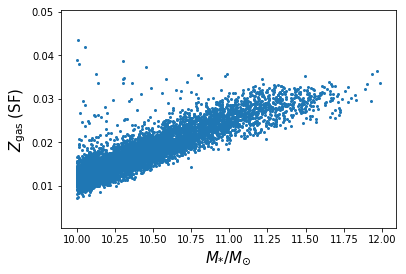

In [20]:
plt.scatter(mstar_30, metallicity, s=4)

plt.xlabel('$M_{*} / M_{\odot}$', size=15)
plt.ylabel('$Z_{\mathrm{gas}} \; (\mathrm{SF})$', size=15)

Stellar mass / SFR

/research/astro/highz/Students/Chris/derivedSFH/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$\\mathrm{log_{10}(SFR)}$')

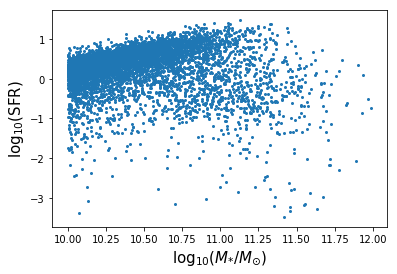

In [21]:
plt.scatter(mstar_30, np.log10(sfr), s=4)

plt.xlabel('$\mathrm{log_{10}}(M_{*} / M_{\odot})$', size=15)
plt.ylabel('$\mathrm{log_{10}(SFR)}$', size=15)